### Overview  <a name='top' />

This notebook will cover the introduction to decision trees. 

The topics that will be covered are:

*  <a href=#Classification_dt>Decision Tree for Classification</a>
*  <a href=#note_eval>Node Evaluation</a>
*  <a href=#tree_induct>Decision Tree Induction</a>
*  <a href=#Prediction>Decision Tree Prediction</a>
*  <a href=#Validation>Model Validation</a>

You will need to implement code between the comments:

`# Your code starts here` and `# Your code ends here`


In [0]:
# Make sure that the required libraries are installed
# If you are using Google Colab, remember to upload the requirements file before 
# running this cell
# If you are running this notebook locally, the requirements file needs to be in 
# the same location as this notebook
import sys
!{sys.executable} -m pip install -r requirements_week04.txt

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# From sklearn import ...
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import pprint
import seaborn

### Dataset to be used

We again use from iris dataset in this exercise

In [0]:
def plot_iris_dataset(X, Y, x_label = 'sepal length (cm)', y_label = 'sepal width (cm)'):
    # Split the 3 classes
    setosa_indx = Y == 0
    versicolour_indx = Y == 1
    virginica_indx = Y == 2

    # Scatter plotting the data, filtering them according the pos/neg values
    plt.scatter(X[setosa_indx, 0], X[setosa_indx, 1], s=30, c='darkgreen', marker='o', label='setosa')
    plt.scatter(X[versicolour_indx, 0], X[versicolour_indx, 1], s=30, c='red', marker='o', label='versicolour')
    plt.scatter(X[virginica_indx, 0], X[virginica_indx, 1], s=30, c='darkblue', marker='o', label='virginica')

    # Labels and limits
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(X[:, 0].min()-0.1, X[:, 0].max()+0.1)
    plt.ylim(X[:, 1].min()-0.1, X[:, 1].max()+0.1)

    # Legend
    pst = plt.legend(loc='lower right', frameon=True)
    pst.get_frame().set_edgecolor('k')
    
    return plt

#### For continuous variable

You do not need fancy Iris dataset in the beginning of the implementation.
Use the small dummy dataset to verify if the function behave properly. The dataset is in the format of combination of input features and class lable

In [0]:
dataset = np.array([[2.771244718,1.784783929,0],
    [1.728571309,1.169761413,0],
    [3.678319846,2.81281357,0],
    [3.961043357,2.61995032,0],
    [2.999208922,2.209014212,0],
    [7.497545867,3.162953546,1],
    [9.00220326,3.339047188,1],
    [7.444542326,0.476683375,1],
    [10.12493903,3.234550982,1],
    [6.642287351,3.319983761,1]])
# input feature
dataset_X = dataset[:,0:2]
# class label
dataset_Y = dataset[:,-1]


## Classification with Decision Tree<a name='Classification_dt' />

We will implement an decision tree for continuous attributes. In general, we can divide the implementation into four parts: Node Evaluation, Tree Induction, Pruning and Prediction.

### Node Evaluation <a name='note_eval' />

In order to implement tree induction, namely grow a tree. We need to first define the behavior of individual notes.

When a node split we need to do:

*  Split data attributes into child branches
*  Create Spliting function: the impurity measure
*  Evaluate all splits and retain the best split 


#### Categorial Attribuite 2 methods: you can get it from modifying numeric split

#### Numeric Attribuite Split

In [0]:
## Split a subset of Data based on numeric attributes

def split_node(dimension, value, data):
    """
    Implement a function that separate data attributes into two group
    
    :param: dimension: the index of the feature with which we used for split
    :param: value: the threshold value for splitting
    :param: data: input data from dataset. Please follow the format of <dataset>
    :returns: Two seperate arrays of data attribute assined to different nodes
    """
    # The left and right value has different length
    left, right = list(), list()
    # Your code starts here
    for row in data:
        if row[dimension] < value:
            left.append(row.tolist())
        else:
            right.append(row.tolist())
    # Your code ends here
    return np.array(left), np.array(right)

x, y = split_node(1, 2, dataset)
print(x,y)
split_test = split_node(1, 2, dataset)
print(split_test)

[[2.77124472 1.78478393 0.        ]
 [1.72857131 1.16976141 0.        ]
 [7.44454233 0.47668338 1.        ]] [[ 3.67831985  2.81281357  0.        ]
 [ 3.96104336  2.61995032  0.        ]
 [ 2.99920892  2.20901421  0.        ]
 [ 7.49754587  3.16295355  1.        ]
 [ 9.00220326  3.33904719  1.        ]
 [10.12493903  3.23455098  1.        ]
 [ 6.64228735  3.31998376  1.        ]]
(array([[2.77124472, 1.78478393, 0.        ],
       [1.72857131, 1.16976141, 0.        ],
       [7.44454233, 0.47668338, 1.        ]]), array([[ 3.67831985,  2.81281357,  0.        ],
       [ 3.96104336,  2.61995032,  0.        ],
       [ 2.99920892,  2.20901421,  0.        ],
       [ 7.49754587,  3.16295355,  1.        ],
       [ 9.00220326,  3.33904719,  1.        ],
       [10.12493903,  3.23455098,  1.        ],
       [ 6.64228735,  3.31998376,  1.        ]]))


#### Evaluate the impurity with Gini Index

The Gini Index of **each splited node from split_node(dimension, value, data)** can be evaluated by formular on slide 15.

$$
\text{Gini} = 1 - \sum_i^C (p_i)^2
$$

Then the impurity of one possible split is calculated by weighted average of Gini Index of splited nodes on slide 18.
$$
I_m = \sum_j \frac{N_{mj}}{N_m} \text{Gini}_m
$$

In [0]:
def get_probabilities(branch_classes, clas):
    class_indx = branch_classes == clas
    p = 0.0
    p = np.sum(class_indx) / len(branch_classes)
    return p
    
# Calculate the Gini index for a split dataset
def gini_index(branches_classes, classes):
    """
    Implement the impurity function here.
    :param: branches_classes: the class label lists of trainning data fall 
            into different nodes. Each row is for each splitted node. See 
            testing code below.
    :param: the list of classe labels that exist in the dataset.
    """
    # count all samples being split 
    total = float(sum([len(branch) for branch in branches_classes]))
    
    gini_imp = 0.0
    for branch_classes in branches_classes:
        size = float(len(branch_classes))
        if size == 0:
            continue
        score = 0.0
        # Your code starts here
        # gini score of each the branch based on the score for each class
        for ci in range(classes.shape[0]):
            p = get_probabilities(branch_classes, classes[ci])
            score += p * p
        # weight the branch score by its relative size
        gini_imp += (1.0 - score) * (size / total)
        # Your code ends here
    return gini_imp


a = [np.array([2,2,2,2]),np.array([2,2,2])]
print(gini_index(a,np.array([1,2])))

a = [np.array([0,2,0,2]),np.array([0,2,0,2])]
print(gini_index(a,np.array([0,2])))

0.0
0.5


#### Evaluate all splits

Now we can loop over all split points in all feature dimensions and select the one with the lowest **Impurity**

For simplicity we split at each data points instead of midpoints mentioned on page 9 in slides 

<a href=#top>back to top<a>

In [0]:
## Evaluate all splits and retain the best ones
Observe_GINI = 0
def get_split(dataset):
    class_values = np.array(list(set(dataset[:,-1])))
    b_index, b_value, b_score, subtree = 999, 999, 999, None

    for index in range(dataset.shape[1]-1): # Think about why?
        for row in dataset:
            branches = split_node(index, row[index], dataset)
            branches_classes = list()
            ## handle empty lists
            for ib in range(len(branches)):
                if branches[ib].size == 0:
                    branches_classes.append(np.array([]))
                else:
                    branches_classes.append(branches[ib][:,-1])
            gini = gini_index(branches_classes, class_values)
            if Observe_GINI == 1:
                print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))

            if gini < b_score:
                b_index, b_value, b_score, subtree = index, row[index], gini, branches
    return {'index':b_index, 'value':b_value, 'subtree':subtree}

In [0]:
Observe_GINI = 1
split = get_split(dataset)
Observe_GINI = 0
print(split)
x,y=split['subtree']


X1 < 2.771 Gini=0.444
X1 < 1.729 Gini=0.500
X1 < 3.678 Gini=0.286
X1 < 3.961 Gini=0.167
X1 < 2.999 Gini=0.375
X1 < 7.498 Gini=0.286
X1 < 9.002 Gini=0.375
X1 < 7.445 Gini=0.167
X1 < 10.125 Gini=0.444
X1 < 6.642 Gini=0.000
X2 < 1.785 Gini=0.500
X2 < 1.170 Gini=0.444
X2 < 2.813 Gini=0.320
X2 < 2.620 Gini=0.417
X2 < 2.209 Gini=0.476
X2 < 3.163 Gini=0.167
X2 < 3.339 Gini=0.444
X2 < 0.477 Gini=0.500
X2 < 3.235 Gini=0.286
X2 < 3.320 Gini=0.375
{'index': 0, 'value': 6.642287351, 'subtree': (array([[2.77124472, 1.78478393, 0.        ],
       [1.72857131, 1.16976141, 0.        ],
       [3.67831985, 2.81281357, 0.        ],
       [3.96104336, 2.61995032, 0.        ],
       [2.99920892, 2.20901421, 0.        ]]), array([[ 7.49754587,  3.16295355,  1.        ],
       [ 9.00220326,  3.33904719,  1.        ],
       [ 7.44454233,  0.47668338,  1.        ],
       [10.12493903,  3.23455098,  1.        ],
       [ 6.64228735,  3.31998376,  1.        ]]))}


### Tree Induction <a name='tree_induct' />

Now we have a fully functioning note that can split. In order to learn a tree that is meanningful to us, we should implement what follows: 

*  Define a leaf node
*  Recursive Algorithm
*  Terminal Condition: 
        

#### Define a leaf
When there is no need to split the tree, namely terminal condition is met, we need set the value of the leaf node to a definite class which represent the most attribute fallen into this node

<a href=#top>back to top<a>

In [0]:
## create a leaf node
def to_leaf(branch):
    """
    Implement a function that assigns a node with the most labels, resulting
            in a leaf note. You have to count number of distinct labels 
            falling into this node 
    :param: branch: all the of data attributes falls into this note
    :returns: the label of the most attributes which fall into this note  
    """
    if branch.size == 0:
     # Your code starts here
        return 0
   
    classes = branch[:,-1]
    counts = np.bincount(classes.astype(int))
    label = np.argmax(counts)
     # Your code ends here
    return label

#### Recursive Algorithm
The function are recursively called until the a branch reaches its terminated conditions. 

We use a dictionary item 'subtree' to record the splited attribute. It is replaced with 'left' and 'right' after the data 'subtree' is used and no longer needed.

The algorithm is terminated when
        1. Only one class in a group: no split
        2. Maximum Tree Depth
        3. Minimum number of attributes

In [0]:
## Recursive function for spliting

def split(node, max_depth, min_size, depth):
    """
    The recursive funtion that construct tree from root
    """
    left, right = node['subtree']
    del(node['subtree'])
    # Your code starts here
    
    # condition 1: All of the instances of data are assigned to left or right
    if left.size == 0 or right.size == 0:
        node['left'] = node['right'] = to_leaf(left) + to_leaf(right)
        return
    # condition 2: check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_leaf(left), to_leaf(right)
        return
    # Your code ends here
    
    # process left child, condition 3: Minimum number of instances
    if len(left) <= min_size:
        node['left'] = to_leaf(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child, condition 3: Minimum number of instances
    if len(right) <= min_size:
        node['right'] = to_leaf(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [0]:
## Start Tree Induction, and get the results
def tree_induct(X_train, Y_train, max_depth, min_size):
    # Combine data
    data = np.append(X_train, Y_train.reshape(Y_train.size,1), axis = 1)

    root = get_split(data)
    split(root, max_depth, min_size, 1)
    return root

In [0]:
tree = tree_induct(dataset_X, dataset_Y, 3, 1)
pprint.pprint(tree)

{'index': 0,
 'left': {'index': 0,
          'left': 0,
          'right': {'index': 0, 'left': 0, 'right': 0, 'value': 2.771244718},
          'value': 2.771244718},
 'right': {'index': 0,
           'left': {'index': 0, 'left': 1, 'right': 1, 'value': 7.444542326},
           'right': {'index': 0, 'left': 1, 'right': 1, 'value': 7.497545867},
           'value': 7.497545867},
 'value': 6.642287351}


#### Let us compare the tree data $\uparrow$ with the structure of the tree $\downarrow$

In [0]:
# Print the structure of a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*3*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*3*' ', node)))
print_tree(tree,3)

         [X1 < 6.642]
            [X1 < 2.771]
               [0]
               [X1 < 2.771]
                  [0]
                  [0]
            [X1 < 7.498]
               [X1 < 7.445]
                  [1]
                  [1]
               [X1 < 7.498]
                  [1]
                  [1]


### Prediction<a name='Prediction' />

Having the tree trained from training data, we can use the data to predict the class labels given new input features. 

This is done by assign attributes from root until it reach a note. The label of that note is the classification result of that attribute.

<a href=#top>back to top<a>

In [0]:

# Make a prediction with a decision tree
def tree_predict(node,  row):
    """
    Implement a function that is recursively called 
    :param: node: a node in the tree, starting from the root. If it is 
                not leaf, it will call its child notes.
    :param: row: a vector of input feature without label
    :result: the predicted label from the tree
    """
    # Your code starts here
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return tree_predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return tree_predict(node['right'], row)
        else:
            return node['right']
    # Your code ends here

In [0]:
test = np.append(dataset_X, dataset_Y.reshape(dataset_Y.size,1), axis = 1)
for row in test:
    prediction = tree_predict(tree, row)
    print('Expected=%d, Got=%d' % (row[-1], prediction))

Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1


### Model Validation<a name='Validation' />

So far, we have seen how to learn a decision tree and how to make prediction with the learned tree. 

However, we only tested the prediction with its training data. In reality, it does not gurantee the quality of the tree. Therefore we need to valid the data using test dataset as discussed in 23-25.

Now we consider the Iris dataset from the real world. We use hold out method for valudation

<a href=#top>back to top<a>

X_train.shape: (105, 2)
Y_train.shape: (105,)
X_test.shape: (45, 2)
Y_test.shape: (45,)


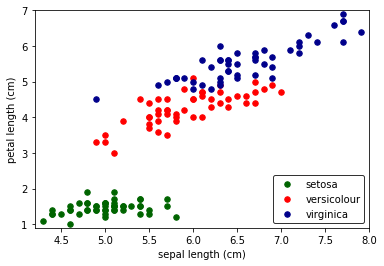

In [0]:
# Load the Iris dataset (which is a python dictionary)
iris_dataset = load_iris()

# Fetch the desired columns and process the data
Y = iris_dataset['target']

# Select the 'RM' and 'LSTAT' columns from the dataset
used_features = ['sepal length (cm)', 'petal length (cm)']
data_col = list()
for col, val in enumerate(iris_dataset['feature_names']):
    if(val in used_features):
        data_col.append(col)

X = iris_dataset['data'][:,data_col]

# use train_test_split() in <sklearn> package to split dataset into train and test sets

# # Your code starts here
random_seed = np.random
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=random_seed)
# Your code ends here

# Printing shape of data
print('X_train.shape: {}'.format(X_train.shape))
print('Y_train.shape: {}'.format(Y_train.shape))
print('X_test.shape: {}'.format(X_test.shape))
print('Y_test.shape: {}'.format(Y_test.shape))

# Plot the databb
plot_iris_dataset(X, Y, x_label=used_features[0], y_label=used_features[1]);

#### Now let us train a decision tree with our dataset with the training set

In [0]:
iris_tree = tree_induct(X_train, Y_train, 5, 1)
pprint.pprint(iris_tree)

{'index': 1,
 'left': {'index': 0,
          'left': {'index': 0,
                   'left': {'index': 0, 'left': 0, 'right': 0, 'value': 4.3},
                   'right': {'index': 0, 'left': 0, 'right': 0, 'value': 4.8},
                   'value': 4.8},
          'right': {'index': 0, 'left': 0, 'right': 0, 'value': 4.9},
          'value': 4.9},
 'right': {'index': 1,
           'left': {'index': 0,
                    'left': {'index': 0,
                             'left': 1,
                             'right': {'index': 0,
                                       'left': 1,
                                       'right': 1,
                                       'value': 5.0},
                             'value': 5.0},
                    'right': {'index': 0, 'left': 1, 'right': 1, 'value': 6.6},
                    'value': 6.6},
           'right': {'index': 1,
                     'left': {'index': 0,
                              'left': {'index': 0,
                     

#### Now test the decision tree with the test set

In [0]:
test = np.append(X_test, Y_test.reshape(Y_test.size,1), axis = 1)
prediction_set = np.array([])
for row in test:
    prediction = tree_predict(iris_tree, row)
    prediction_set = np.append(prediction_set,prediction)
#   print('Expected=%d, Got=%d' % (row[-1], prediction))
    

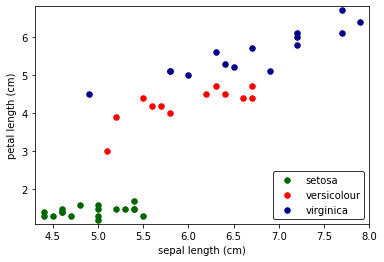

In [0]:
# The ground truth data
plot_iris_dataset(X_test, Y_test, x_label=used_features[0], y_label=used_features[1]);


#### We can visualize the decision boundry by: What happens if you increase the depth from 1 to 5

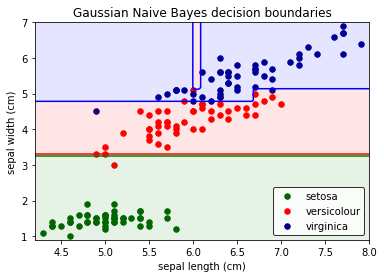

In [0]:
num_points = 100
x_mesh = np.linspace(4, 8, num_points)
y_mesh = np.linspace(0.5, 7.5, num_points)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)

Z = np.array(  [tree_predict( iris_tree, np.array([xx,yy]).reshape(-1,1)) 
                     for xx, yy in zip(np.ravel(x_mesh), np.ravel(y_mesh)) ] )
# Reshaping the predicted class into the meshgrid shape
z_mesh = Z.reshape(x_mesh.shape)

#Plot the filled and boundary contours
plt = plot_iris_dataset(X, Y);

plt.contourf( x_mesh, y_mesh, z_mesh, 2, alpha = .1, colors = ('green','red', 'blue'))
plt.contour( x_mesh, y_mesh, z_mesh, 2, alpha = 1, colors = ('green','red', 'blue'))

# Addd axis and title
plt.title('Gaussian Naive Bayes decision boundaries');

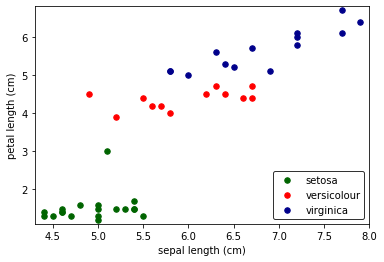

In [0]:
# The result of prediction

plot_iris_dataset(X_test, prediction_set, x_label=used_features[0], y_label=used_features[1]);

#### We can see at the bountary, the prediction is not very relliable. The accuracy of the prediction of this training is:

In [0]:
np.sum(prediction_set == Y_test)/len(Y_test)

0.9333333333333333

#### Another metric for quality of prediction is  True Positive, True Negative, False Positive, False Negative in the confusion matrix

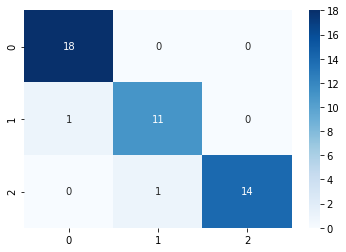

In [0]:
seaborn.heatmap(confusion_matrix(Y_test, prediction_set), annot=True, fmt='', cmap='Blues')

## Off the shelf solution

Once you have understand the principal, in practice, we can find off-the-shelf implementation. 

<a href=#top>back to top<a>

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data

/home/c7031195/Programming/python3/env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:

## Training

dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

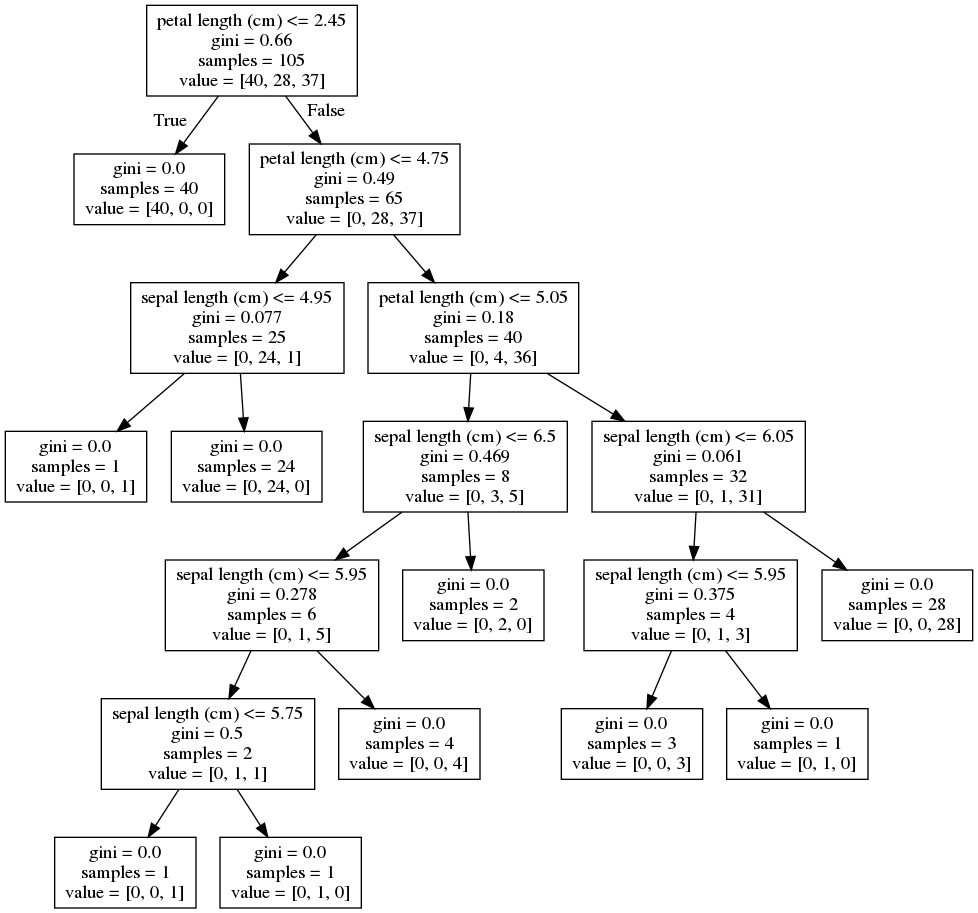

In [0]:
## You can check your decision tree by:

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, 
                feature_names=used_features)

(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [0]:
y_pred = dt.predict(X_test)